In [ ]:
# imports
import pandas as pd
import pymongo
import numpy as np


In [ ]:
# Setting up database connection with Mongo DB

client = pymongo.MongoClient("mongodb://localhost/")

db_mongo = client.song_data
info_db = db_mongo.techno_info
features_db = db_mongo.techno_features
analysis_db = db_mongo.techno_analysis

In [ ]:
# Read data from database

song_infos = pd.DataFrame(list(info_db.find()))
song_features = pd.DataFrame(list(features_db.find()))
song_analysis = pd.DataFrame(list(analysis_db.find()))

In [ ]:
merged_data = pd.merge(left=song_infos.drop_duplicates("id"),
                       right=song_features.drop_duplicates("id"),
                       left_on="id",
                       right_on="id",
                       how="inner")

import tqdm
for i, z in tqdm.tqdm(merged_data.iterrows()):
    merged_data.at[i, "artist_id"] = merged_data.at[i, "artists"][0]["id"]
    merged_data.at[i, "album_id"] = merged_data.at[i, "album"]["id"]
    merged_data.at[i, "release_date"] = merged_data.at[i, "album"]["release_date"]
    merged_data.at[i, "total_tracks"] = merged_data.at[i, "album"]["total_tracks"]

merged_data.drop(["album", "artists", "_id_x", "_id_y", "duration_ms_x", "duration_ms_y", "external_ids", "external_urls",
                  "href", "is_local", "is_playable", "linked_from",
                  "preview_url", "type_x", "type_y", "uri_x", "uri_y", "restrictions",
                  "track_href", "analysis_url"], axis=1, inplace=True)

merged_data = pd.merge(left=merged_data,
                       right=song_analysis.drop_duplicates("id"),
                       left_on="id",
                       right_on="id",
                       how="inner")

merged_data.drop(["_id", "key_x", "loudness_x", "mode_x", "tempo_x", "time_signature_x"], axis=1, inplace=True)

In [ ]:
merged_data.rename(columns={'mode_y':'mode', "tempo_y":"tempo", "time_signature_y":"time_signature", "key_y":"key", "loudness_y":"loudness"}, inplace=True)

In [ ]:
X_train = merged_data[50:].drop(["popularity","id","name","artist_id","album_id","release_date"], axis=1)
X_test = merged_data[:50].drop(["popularity","id","name","artist_id","album_id","release_date"], axis=1)
y = merged_data["popularity"]
y_test = merged_data["popularity"][:50]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import gc

In [ ]:

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
# split into 67% for train and 33% for test
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [ ]:
y= to_categorical(y)
y_train = y[50:]
y_test = y[:50]



In [156]:
del m
from tensorflow.keras.backend import clear_session
clear_session()
gc.collect()

3175

In [157]:
def build_model():
  model = keras.Sequential([
    layers.Dense(6000, activation='relu', input_shape=(26,)),
    layers.Dense(6000, activation='relu'),
    layers.Dense(96, activation='softmax'),
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics=["accuracy"])
  return model

m = build_model()


In [138]:

# print all layers
print(m.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 12000)             324000    
_________________________________________________________________
dense_9 (Dense)              (None, 6000)              72006000  
_________________________________________________________________
dense_10 (Dense)             (None, 96)                576096    
Total params: 72,906,096
Trainable params: 72,906,096
Non-trainable params: 0
_________________________________________________________________
None


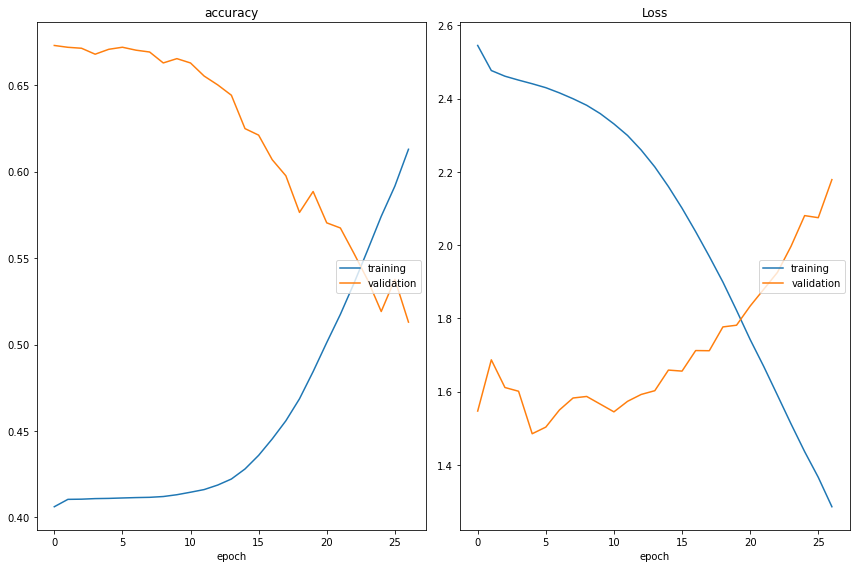

accuracy
	training         	 (min:    0.406, max:    0.613, cur:    0.613)
	validation       	 (min:    0.513, max:    0.673, cur:    0.513)
Loss
	training         	 (min:    1.286, max:    2.545, cur:    1.286)
	validation       	 (min:    1.485, max:    2.179, cur:    2.179)
274/274 [==============================] - 17s 61ms/step - loss: 1.2856 - accuracy: 0.6129 - val_loss: 2.1789 - val_accuracy: 0.5130
Epoch 28/200
 94/274 [=========>....................] - ETA: 10s - loss: 1.1891 - accuracy: 0.6403

KeyboardInterrupt: 

In [158]:
from livelossplot.inputs.tf_keras import PlotLossesCallback

# train the model
h  = m.fit(X_train, y_train, epochs=200, batch_size=800,
           validation_split=0.2,
           callbacks=[PlotLossesCallback()],
           #callbacks=[keras.callbacks.TensorBoard(log_dir="C:\logistic-lemongrass-student-code\\tensorboard", histogram_freq=0, write_graph=True, write_images=False)],
           verbose=1
           )


In [140]:
score = m.evaluate(X_test, y_test, verbose=1)
print(f'Test loss: {score[0]} / MAE: {score[1]}')

911/911 [==============================] - 5s 6ms/step - loss: 1.8055 - accuracy: 0.6046

In [145]:
pred = m.predict_classes(X_test)
pred

array([0, 0, 0, 0, 0, 0, 5, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 5, 0, 0, 0, 0], dtype=int64)

In [148]:
dict(enumerate(y_test[0]))
merged_data.iloc[0]["popularity"]

38

In [ ]:
keras.np_utils.probas_to_classes(y_proba)
m.predict_classes()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RFC_Model = RandomForestClassifier()
RFC_Model.fit(X_train, y_train)
RFC_Predict = RFC_Model.predict(X_valid)
RFC_Accuracy = accuracy_score(y_valid, RFC_Predict)
print("Accuracy: " + str(RFC_Accuracy))

RFC_AUC = roc_auc_score(y_valid, RFC_Predict)
print("AUC: " + str(RFC_AUC))